# Fit global epistasis models to DMS data

The [`dms_variants.globalepistasis`](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis) module is based off the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) -- that there exists an underlying latent phenotype that mutations affect additively, and
then an observed (measured) phenotype that is a non-linear
function of the latent phenotype.


## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import os
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

import yaml

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.6.0


Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [7]:
os.makedirs(config['global_epistasis_binding_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

## Read in Tite-seq affinity scores by barcode
Read in log10Ka measurements. Rename log10Ka column to be func_score, and calculate variance from the ddG_log10Ka column. Remove rows with NaN for func_score. For empty aa_substitutions (wildtype), it is being replaced with NA. Make back to an empty string.

In [8]:
df = pd.read_csv(config['Titeseq_Kds_file'])
df.rename(columns={'log10Ka':'func_score'},inplace=True)
df['func_score_var'] = df['log10SE']**2
func_scores = df[pd.notnull(df['func_score'])]
func_scores.fillna('',inplace=True)
func_scores.head()

,Unnamed: 0,library,target,barcode,variant_call_support,avgcount,func_score,delta_log10Ka,log10SE,Kd,Kd_SE,response,baseline,nMSR,variant_class,aa_substitutions,n_aa_substitutions,func_score_var
2,3,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,74.501274,8.718159,-2.046168,0.123408,1.913555e-09,5.441202e-10,1.643325,1.130245,0.005605,>1 nonsynonymous,A22C R127G E141D L188V,4,0.015230
3,4,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,146.321899,10.348897,-0.415430,0.047944,4.478193e-11,4.947053e-12,2.871835,1.005201,0.000945,1 nonsynonymous,N13F,1,0.002299
5,6,lib1,SARS-CoV-2,AAAAAAAACAGGTTGC,4,47.483006,6.000000,-4.764327,2.000000,1.000000e-06,7.525404e-06,1.500000,1.148506,0.009990,>1 nonsynonymous,V71K P149L N157T,3,4.000000
6,7,lib1,SARS-CoV-2,AAAAAAAACATTAAAT,6,47.441196,10.151655,-0.612672,0.086726,7.052526e-11,1.409304e-11,2.636834,1.085328,0.002777,>1 nonsynonymous,A18V T148S H189Y,3,0.007521
8,9,lib1,SARS-CoV-2,AAAAAAAACCTTACAA,2,18.780856,9.611417,-1.152911,0.191538,2.446715e-10,1.079815e-10,2.001013,1.105333,0.011865,>1 nonsynonymous,T63D A89N,2,0.036687


## Fit global epistasis models
We now fit global epistasis models to the functional scores.
For background on these models, see [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
The models we fits are implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html), which has extensive documentation.

The primary model of interest is [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis), which assumes that the observed phenotype is a monotonic non-linear function of an underlying additive latent phenotype.
As a control, we also fit a [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, which assumes that mutations simply contribute additively to the observed phenotype:

For the fitting, we first convert the set of functional scores into a binary representation using a [BinaryMap]((https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html#dms_variants.binarymap.BinaryMap)).
Then we create the model, fit it, and store it.

In [9]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(epistasistype, likelihoodtype, lib)`

for (lib), scores in func_scores.groupby(['library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, likelihoodtype, lib)] = model

Fitting global epistasis with Gaussian likelihood model to lib1... fitting took 89.2 sec.
Fitting no epistasis with Gaussian likelihood model to lib1... fitting took 3.1 sec.
Fitting global epistasis with Cauchy likelihood model to lib1... fitting took 85.4 sec.
Fitting no epistasis with Cauchy likelihood model to lib1... fitting took 17.5 sec.
Fitting global epistasis with Gaussian likelihood model to lib2... fitting took 12.3 sec.
Fitting no epistasis with Gaussian likelihood model to lib2... fitting took 3.8 sec.
Fitting global epistasis with Cauchy likelihood model to lib2... fitting took 242.3 sec.
Fitting no epistasis with Cauchy likelihood model to lib2... fitting took 25.6 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better. (Note, I previous tried alterning number of meshpoints, and the default 4 was the lowest AIC):

In [10]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, lib), model in models.items()],
            columns=['model', 'likelihood type', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['library'])
    )

logliks_df.round(1)

,model,likelihood type,n_parameters,log_likelihood,AIC
library,,,,,
lib1,global epistasis,Gaussian,3801,-58652.4,124906.8
lib1,no epistasis,Gaussian,3795,-80453.4,168496.9
lib1,global epistasis,Cauchy,3801,-39824.6,87251.3
lib1,no epistasis,Cauchy,3795,-60005.8,127601.5
lib2,global epistasis,Gaussian,3798,-56047.4,119690.8
lib2,no epistasis,Gaussian,3792,-73428.5,154441.0
lib2,global epistasis,Cauchy,3798,-32391.0,72378.1
lib2,no epistasis,Cauchy,3792,-54010.6,115605.2


In [11]:
# check to confirm the global epistasis model is better in all cases
assert (logliks_df
        .reset_index()
        .pivot_table(index=['library'],
                     values='AIC',
                     columns='model'
                     )
        .assign(global_better=lambda x: x['global epistasis'] < x['no epistasis'])
        ['global_better']
        .all()
        )

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis models fit so much better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) models, below we are just going to analyze the results from the global epistasis model.

First, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.

In [12]:
# NBVAL_IGNORE_OUTPUT

variants_df = pd.concat(
        [model.phenotypes_df
         .assign(library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, lib), model in models.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

#predictionsfile = os.path.join(config['global_epistasis_binding_dir'], 'globalepistasis_binding_predictions.csv')
#variants_df.to_csv(predictionsfile, index=False)
#print(f"Writing predictions to {predictionsfile}")

variants_df.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,likelihoodtype
0,A22C R127G E141D L188V,8.72,0.02,-1.02,9.07,lib1,Gaussian
1,N13F,10.35,0.00,-0.46,10.58,lib1,Gaussian
2,V71K P149L N157T,6.00,4.00,-2.92,6.69,lib1,Gaussian
3,A18V T148S H189Y,10.15,0.01,-0.57,10.24,lib1,Gaussian
4,T63D A89N,9.61,0.04,-0.87,9.42,lib1,Gaussian


Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

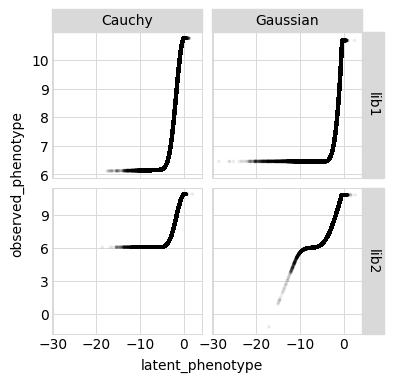

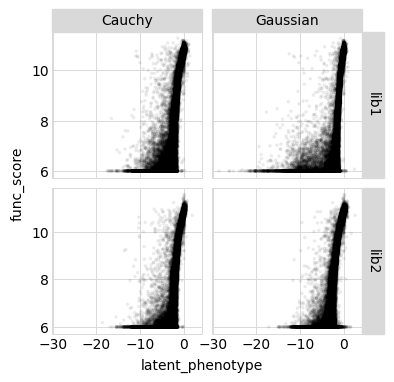

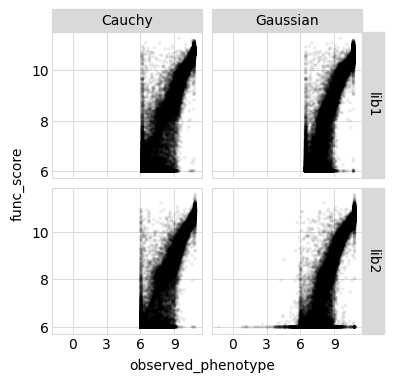

In [13]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

The two Cauchy fits looks good -- clearly picking up on the complete censoring of *K*<sub>A,app</sub> values >10<sup>6</sup> to the 10<sup>6</sup> boundary condition. The Gaussian likelihood model fails to find this boundary in the lib2 data, and in the lib1 data it seems to fit a boundary closer to 7 than to 6. I am curious to see how these curves change when I remove the SE/variance estimates, which get wonky in these values at this boundary (and are of uncertain value even for points within the dynamic range).

The Cauchy likelihood fits also have fewer points that are observed at this boundary condition in the experimental functional scores but given latent phenotypes near neutral (aka, likely "false positives"). Overall, these models that use the Cauchy liklelihood look better, which is consistent with what I've seen from previous Tite-seq results. We will confirm this later on when we evaluate the correlation in coefficients between replicates from these different models.

To get a better view into the "shape" of global epistasis, let's re-make the plots above but only showing single mutant barcodes.

In [14]:
mask = (variants_df['aa_substitutions'].str.len() < 6) & (variants_df['aa_substitutions'].str.len() > 0)
single_variants_df = variants_df.loc[mask]
single_variants_df.head()

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,likelihoodtype
1,N13F,10.348897,0.002299,-0.456929,10.584842,lib1,Gaussian
10,P7S,10.671953,0.008159,-0.076223,10.684103,lib1,Gaussian
21,P149Q,10.718483,0.002085,-0.144518,10.684103,lib1,Gaussian
24,D90Y,10.565768,0.004547,-0.451604,10.601489,lib1,Gaussian
26,L5C,10.689649,0.003073,-0.165232,10.684103,lib1,Gaussian


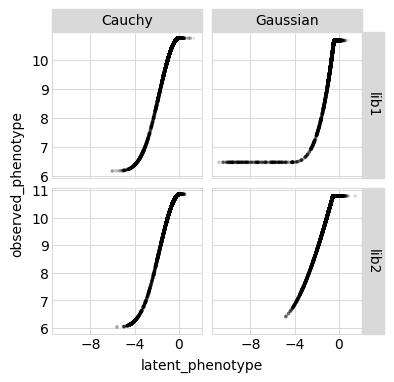

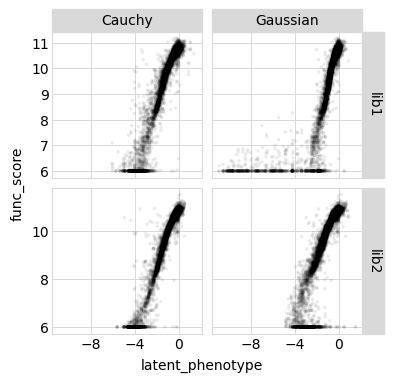

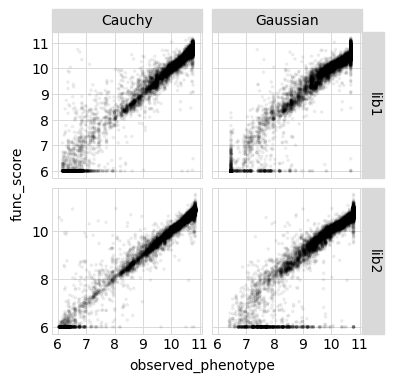

In [15]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(single_variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

In [16]:
#add predicted and latent phenotypes to table by barcode with additional columns used for interpretation, save output file
dt = pd.read_csv(config['Titeseq_Kds_file'])
dt[['aa_substitutions']] = dt[['aa_substitutions']].fillna(value='')

dt = models.get(('global epistasis', 'Gaussian', 'lib1')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_1',observed_phenotype_col='predicted_phenotype_Gaussian_1',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 'lib1')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_1',observed_phenotype_col='predicted_phenotype_Cauchy_1',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Gaussian', 'lib2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_2',observed_phenotype_col='predicted_phenotype_Gaussian_2',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 'lib2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_2',observed_phenotype_col='predicted_phenotype_Cauchy_2',unknown_as_nan=True)

dt.to_csv(config['global_epistasis_binding_file'], index=False)
print(f"Writing predictions to {config['global_epistasis_binding_file']}")

dt.head().round(2)

Writing predictions to results/global_epistasis_binding/global_epistasis_binding_predictions.csv


,Unnamed: 0,library,target,barcode,variant_call_support,avgcount,log10Ka,delta_log10Ka,log10SE,Kd,Kd_SE,response,baseline,nMSR,variant_class,aa_substitutions,n_aa_substitutions,latent_phenotype_Gaussian_1,predicted_phenotype_Gaussian_1,latent_phenotype_Cauchy_1,predicted_phenotype_Cauchy_1,latent_phenotype_Gaussian_2,predicted_phenotype_Gaussian_2,latent_phenotype_Cauchy_2,predicted_phenotype_Cauchy_2
0,1,lib1,SARS-CoV-2,AAAAAAAAAATTGTAA,1,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,Y91L K199Y,2,-0.26,10.68,-0.33,10.66,-0.45,10.78,-0.33,10.69
1,2,lib1,SARS-CoV-2,AAAAAAAAACTTAAAT,2,4.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,N13S L60P K94N S147T C150Y,5,-3.53,6.51,-4.81,6.19,-5.44,6.20,-4.77,6.07
2,3,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,74.50,8.72,-2.05,0.12,0.0,0.0,1.64,1.13,0.01,>1 nonsynonymous,A22C R127G E141D L188V,4,-1.02,9.07,-1.39,9.43,-1.80,9.03,-1.21,9.68
3,4,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,146.32,10.35,-0.42,0.05,0.0,0.0,2.87,1.01,0.00,1 nonsynonymous,N13F,1,-0.46,10.58,-0.68,10.38,-0.71,10.50,-0.70,10.36
4,5,lib1,SARS-CoV-2,AAAAAAAACAATATAA,1,2.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,C6K T15W K94Y V103W,4,-10.58,6.46,-6.06,6.16,-6.15,6.07,-7.14,6.04


## Fit global epistasis models with differing number of basis iSplines
Let's try fitting global epistasis models with varying numbers of basis iSpline functions. The default number is 5 basis functions. What happens if we vary between 1 and 4, compared to the plots above with the 5? Since Cauchy likelihood appears to perform better (which we will confirm in the subsequent analysis), we will infer models with the Cauchy likelihood evaluation. 

In [17]:
# NBVAL_IGNORE_OUTPUT

models_meshpoints = {}  # store models, keyed by `(epistasistype, meshpoints, lib)`

for (lib), scores in func_scores.groupby(['library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, meshpoints, Model in [
            ('global epistasis', 4, dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('global epistasis', 3, dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('global epistasis', 2, dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with Cauchy likelihood model and {meshpoints} meshpoints to {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap,meshpoints=meshpoints)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models_meshpoints[(epistasistype, meshpoints, lib)] = model

Fitting global epistasis with Cauchy likelihood model and 4 meshpoints to lib1... fitting took 74.6 sec.
Fitting global epistasis with Cauchy likelihood model and 3 meshpoints to lib1... fitting took 113.6 sec.
Fitting global epistasis with Cauchy likelihood model and 2 meshpoints to lib1... fitting took 117.7 sec.
Fitting global epistasis with Cauchy likelihood model and 4 meshpoints to lib2... fitting took 208.0 sec.
Fitting global epistasis with Cauchy likelihood model and 3 meshpoints to lib2... fitting took 92.9 sec.
Fitting global epistasis with Cauchy likelihood model and 2 meshpoints to lib2... fitting took 133.8 sec.


Check out the log-likelihood and AIC of models fit with differing numbers of meshpoints.

In [18]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, meshpoints, lib, model.nparams, model.loglik) for
             (epistasistype, meshpoints, lib), model in models_meshpoints.items()],
            columns=['model', 'likelihood type', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['library'])
    )

logliks_df.round(1)

,model,likelihood type,n_parameters,log_likelihood,AIC
library,,,,,
lib1,global epistasis,4,3801,-39824.6,87251.3
lib1,global epistasis,3,3800,-45726.4,99052.9
lib1,global epistasis,2,3799,-38587.1,84772.3
lib2,global epistasis,4,3798,-32391.0,72378.1
lib2,global epistasis,3,3797,-40849.2,89292.5
lib2,global epistasis,2,3796,-32098.4,71788.8


Below, we get a sense of the shape of global epistasis when varying the number of underlying iSpline basis functions across the different meshpoint parameter values.

In [19]:
# NBVAL_IGNORE_OUTPUT

variants_df_meshpoints = pd.concat(
        [model.phenotypes_df
         .assign(library=lib,
                 meshpoints=meshpoints,
                 )
         for (epistasistype, meshpoints, lib), model in models_meshpoints.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

#predictionsfile = os.path.join(config['global_epistasis_binding_dir'], 'globalepistasis_binding_predictions.csv')
#variants_df.to_csv(predictionsfile, index=False)
#print(f"Writing predictions to {predictionsfile}")

variants_df_meshpoints.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,meshpoints
0,A22C R127G E141D L188V,8.72,0.02,-1.39,9.43,lib1,4
1,N13F,10.35,0.00,-0.68,10.38,lib1,4
2,V71K P149L N157T,6.00,4.00,-6.84,6.15,lib1,4
3,A18V T148S H189Y,10.15,0.01,-0.87,10.17,lib1,4
4,T63D A89N,9.61,0.04,-1.29,9.59,lib1,4


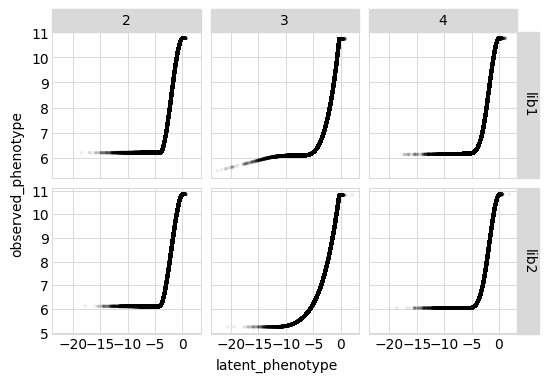

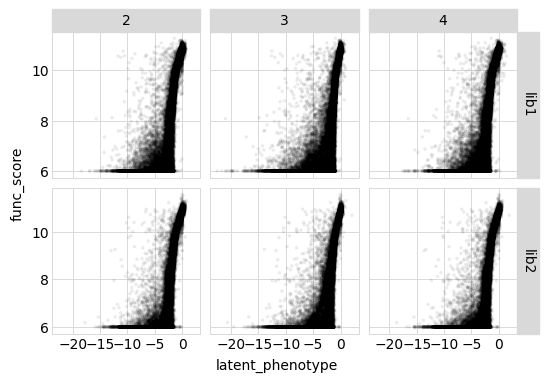

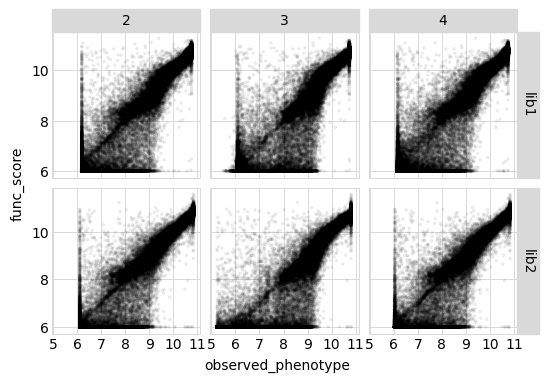

In [20]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_meshpoints, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ meshpoints', scales='free_y') +
        theme(figure_size=(2 * variants_df_meshpoints['meshpoints'].nunique(),
                           2 * variants_df_meshpoints['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

Not too much difference when changing the number of meshpoints. The lib1 fit with 2 meshpoints removed the upper censoring, but looks worse in other contexts, and AIC still favors the four-meshpoint model.

## Repeat fits for pooled library measurements

Repeat the fits for all barcodes pooled together. There is slight variation in the average *K*<sub>D,app</sub> ascribed to wildtype genotypes in each library. To account for this, express the functional score in each library as the delta_log10Ka relative to the average of wildtype measurements in that library, thereby standardizing the small difference in mean WT between the two replicates and avoiding consequential artefacts in a joint fit.

In [21]:
df_joint = pd.read_csv(config['Titeseq_Kds_file'])
df_joint.rename(columns={'delta_log10Ka':'func_score'},inplace=True)
df_joint['func_score_var'] = df_joint['log10SE']**2
func_scores_joint = df_joint[pd.notnull(df_joint['func_score'])]
func_scores_joint.fillna('',inplace=True)
func_scores_joint.head()

,Unnamed: 0,library,target,barcode,variant_call_support,avgcount,log10Ka,func_score,log10SE,Kd,Kd_SE,response,baseline,nMSR,variant_class,aa_substitutions,n_aa_substitutions,func_score_var
2,3,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,74.501274,8.718159,-2.046168,0.123408,1.913555e-09,5.441202e-10,1.643325,1.130245,0.005605,>1 nonsynonymous,A22C R127G E141D L188V,4,0.015230
3,4,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,146.321899,10.348897,-0.415430,0.047944,4.478193e-11,4.947053e-12,2.871835,1.005201,0.000945,1 nonsynonymous,N13F,1,0.002299
5,6,lib1,SARS-CoV-2,AAAAAAAACAGGTTGC,4,47.483006,6.000000,-4.764327,2.000000,1.000000e-06,7.525404e-06,1.500000,1.148506,0.009990,>1 nonsynonymous,V71K P149L N157T,3,4.000000
6,7,lib1,SARS-CoV-2,AAAAAAAACATTAAAT,6,47.441196,10.151655,-0.612672,0.086726,7.052526e-11,1.409304e-11,2.636834,1.085328,0.002777,>1 nonsynonymous,A18V T148S H189Y,3,0.007521
8,9,lib1,SARS-CoV-2,AAAAAAAACCTTACAA,2,18.780856,9.611417,-1.152911,0.191538,2.446715e-10,1.079815e-10,2.001013,1.105333,0.011865,>1 nonsynonymous,T63D A89N,2,0.036687


In [22]:
# NBVAL_IGNORE_OUTPUT

models_joint = {}  # store models, keyed by `(epistasistype, likelihoodtype)`

for (target), scores in func_scores_joint.groupby(['target']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models_joint[(epistasistype, likelihoodtype)] = model


Fitting global epistasis with Gaussian likelihood model... fitting took 89.1 sec.
Fitting no epistasis with Gaussian likelihood model... fitting took 7.4 sec.
Fitting global epistasis with Cauchy likelihood model... fitting took 152.9 sec.
Fitting no epistasis with Cauchy likelihood model... fitting took 35.1 sec.


In [23]:
# NBVAL_IGNORE_OUTPUT

variants_df_joint = pd.concat(
        [model.phenotypes_df
         .assign(likelihoodtype=likelihoodtype)
         for (epistasistype, likelihoodtype), model in models_joint.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

variants_df_joint.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,likelihoodtype
0,A22C R127G E141D L188V,-2.05,0.02,-1.49,-1.79,Gaussian
1,N13F,-0.42,0.00,-0.64,-0.23,Gaussian
2,V71K P149L N157T,-4.76,4.00,-3.71,-3.90,Gaussian
3,A18V T148S H189Y,-0.61,0.01,-0.87,-0.71,Gaussian
4,T63D A89N,-1.15,0.04,-1.20,-1.31,Gaussian


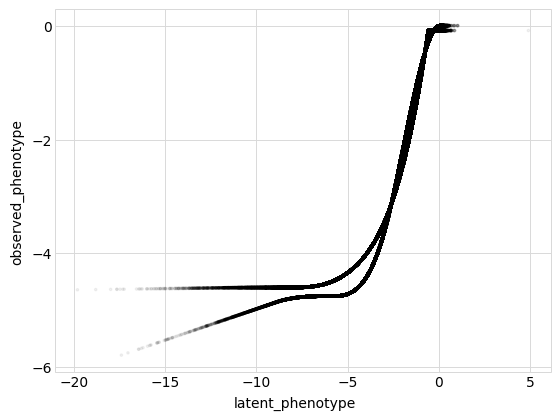

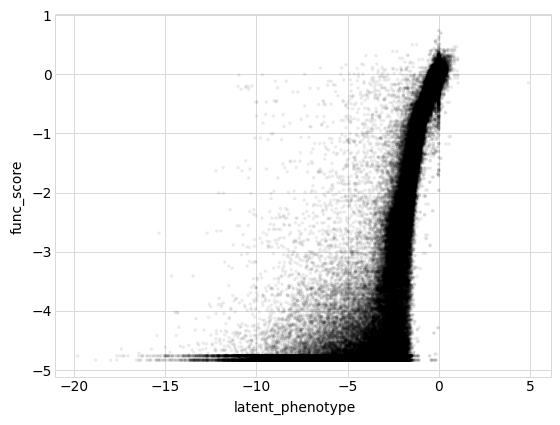

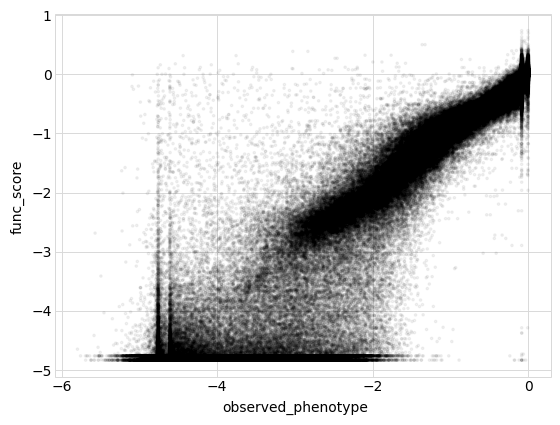

In [24]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_joint, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5))
#        facet_grid('likelihoodtype', scales='free_y') +
#        theme(figure_size=(2 * variants_df_novar['likelihoodtype'].nunique()),
#              )
#        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

We will look more at each of these models (Cauchy and Gaussian likelihoods, observed and latent scale measurements) in the next notebook, in which we evaluate coefficients, process our final phenotype map, and compare our measurements to some validation datasets.

## Output epistasis model parameters


In [25]:
#lib1 models
models.get(('global epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-latent-effects_binding_1.csv',index=False)
models.get(('global epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-predicted-effects_binding_1.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-latent-effects_binding_1.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-predicted-effects_binding_1.csv',index=False)
models.get(('no epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Gaussian-predicted-effects_binding_1.csv',index=False)
models.get(('no epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Cauchy-predicted-effects_binding_1.csv',index=False)
#lib2 models
models.get(('global epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-latent-effects_binding_2.csv',index=False)
models.get(('global epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-predicted-effects_binding_2.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-latent-effects_binding_2.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-predicted-effects_binding_2.csv',index=False)
models.get(('no epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Gaussian-predicted-effects_binding_2.csv',index=False)
models.get(('no epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Cauchy-predicted-effects_binding_2.csv',index=False)
#joint models
models_joint.get(('global epistasis', 'Gaussian')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-latent-effects_binding_joint.csv',index=False)
models_joint.get(('global epistasis', 'Gaussian')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-predicted-effects_binding_joint.csv',index=False)
models_joint.get(('global epistasis', 'Cauchy')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-latent-effects_binding_joint.csv',index=False)
models_joint.get(('global epistasis', 'Cauchy')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-predicted-effects_binding_joint.csv',index=False)
models_joint.get(('no epistasis', 'Gaussian')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Gaussian-predicted-effects_binding_joint.csv',index=False)
models_joint.get(('no epistasis', 'Cauchy')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Cauchy-predicted-effects_binding_joint.csv',index=False)




In [26]:
#! jupyter nbconvert --to markdown global_epistasis_binding.ipynb --output-dir ./results/summary/ --output global_epistasis_binding.md